# Merging segmentation masks
You can merge segmentation masks into one. The masks to be merged should always be ordererd by small to big. You can also add labels directly.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spatial_data
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
xr.set_options(display_style='text')

In [3]:
ds = xr.load_dataset('/g/huber/projects/CITEseq/CODEX/BNHL_TMA/bhnl_labeled_zarr/166_4_I2_LK_labeled.zarr').pp[1000:1300, 1000:1300]

/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/meyerben/meyerben/.conda/envs/spatialproteomics_env/lib/python3.9/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [4]:
# segmenting on CD11c (dendritic cells) and CD68 (macrophages) and getting the result as a numpy array
new_segmentations = ds.ext.cellpose(channels=['CD11c', 'CD68'], return_xarray=False)

TORCH CUDA version not installed/working.
>>>> using CPU
>> cyto3 << model set to be used
>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
channels set to [0, 0]
~~~ ESTIMATING CELL DIAMETER(S) ~~~
estimated cell diameter(s) in 19.42 sec
>>> diameter(s) = 
[ 20.95 ]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 35.98 sec
channels set to [0, 0]
~~~ ESTIMATING CELL DIAMETER(S) ~~~
estimated cell diameter(s) in 15.75 sec
>>> diameter(s) = 
[ 21.76 ]
~~~ FINDING MASKS ~~~
>>>> TOTAL TIME 29.31 sec


In [5]:
new_segmentations.shape

(2, 301, 301)

In [10]:
ds

<xarray.Dataset>
Dimensions:        (cells: 314, channels: 56, y: 301, x: 301, labels: 8,
                    props: 2, features: 4)
Coordinates:
  * cells          (cells) int64 3185 3215 3236 3237 ... 4715 4718 4728 4729
  * channels       (channels) <U11 'DAPI' 'Helios' 'CD10' ... 'CD79a' 'Ki-67'
  * features       (features) <U10 'centroid-0' 'centroid-1' ... '_original_'
  * labels         (labels) int64 1 2 3 4 5 6 7 8
  * props          (props) <U6 '_color' '_name'
  * x              (x) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
  * y              (y) int64 1000 1001 1002 1003 1004 ... 1297 1298 1299 1300
Data variables:
    _arcsinh_mean  (cells, channels) float64 3.145 0.101 1.386 ... 0.7508 0.4342
    _arcsinh_sum   (cells, channels) float64 8.73 3.989 6.909 ... 5.641 5.032
    _image         (channels, y, x) uint8 72 72 72 69 79 92 109 ... 3 2 3 3 2 3
    _labels        (labels, props) object 'C3' ... 'B (PAX5)'
    _obs           (cells, features) float64 1.085e+03 1.296e+03 6.0 ... 4.0 3.0
    _raw_mean      (cells, channels) float64 57.93 0.5056 9.375 ... 4.117 2.24
    _raw_sum       (cells, channels) float64 1.547e+04 135.0 ... 704.0 383.0
    _segmentation  (y, x) int64 0 0 0 4319 4319 ... 4014 4014 3481 3481 3481

In [54]:
# merging the segmentation masks
merged_ds = ds.pp.merge_segmentation(new_segmentations, labels=['Dendritic Cell', 'Macrophage'])

/g/huber/users/meyerben/notebooks/codex_analysis/2024-03-18_spatialproteomics_package/spatial-data/spatial_data/pp/preprocessing.py:27: AccessorRegistrationWarning: registration of accessor <class 'spatial_data.pp.preprocessing.PreprocessingAccessor'> under name 'pp' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  class PreprocessingAccessor:
Found 'cells' coordinate in '_arcsinh_mean'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_arcsinh_sum'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_obs'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_raw_mean'. Removing layer. Please re-add the layer after merging the segmentation masks.
Found 'cells' coordinate in '_raw_sum'. Removing layer. Please re-add the layer after merging the segmentation masks.


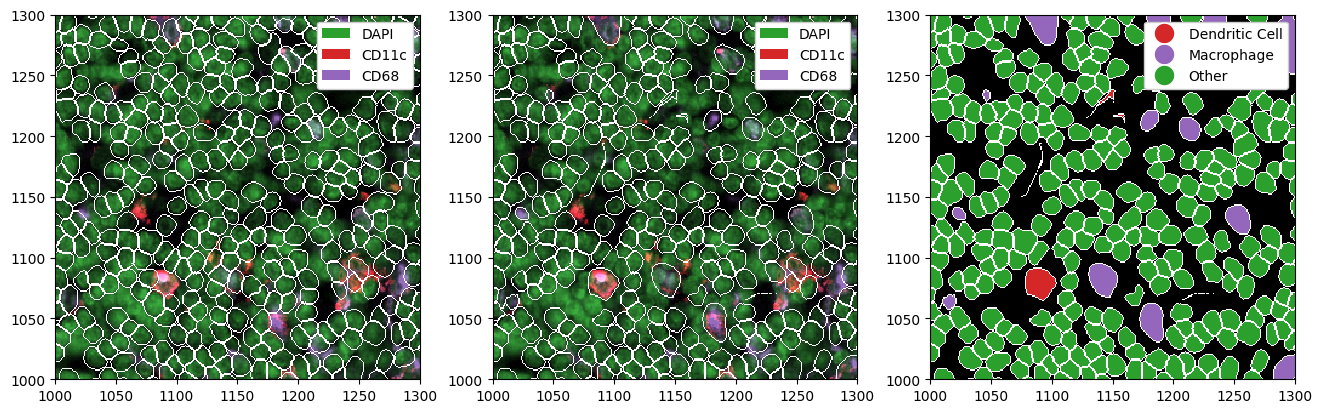

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# adding colors to match the channel colors
merged_ds = merged_ds.la.set_label_color('Other', 'C2')
merged_ds = merged_ds.la.set_label_color('Dendritic Cell', 'C3')
merged_ds = merged_ds.la.set_label_color('Macrophage', 'C4')

# original masks
_ = ds.pp[['DAPI', 'CD11c', 'CD68']].pl.colorize(colors=['C2', 'C3', 'C4']).pl.imshow(render_segmentation=True, legend_background=True, ax=ax[0])

# merged masks
_ = merged_ds.pp[['DAPI', 'CD11c', 'CD68']].pl.colorize(colors=['C2', 'C3', 'C4']).pl.imshow(render_segmentation=True, legend_background=True, ax=ax[1])
_ = merged_ds.pl.imshow(render_intensities=False, render_segmentation=True, render_labels=True, legend_label=True, ax=ax[2])
